In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib
import tqdm
tqdm.tqdm.pandas()

In [3]:
import pandas as pd
import geopandas as gpd
import utm
from haversine import haversine
from scipy.spatial import KDTree, cKDTree

In [4]:
DATA_DIR = pathlib.Path("../../data/")

# Loading data

In [5]:
locations = pd.read_csv(DATA_DIR.joinpath("locations.csv"), header=None)

In [6]:
locations.head()

,0,1
0,42.63914,141.62366
1,36.42835,140.61340
2,42.63864,141.62542
3,36.42911,140.61360
4,36.42957,140.61429


In [7]:
locations.columns = ["lat", "lon"]

In [8]:
locations.max()

lat     78.93490
lon    179.82728
dtype: float64

In [9]:
locations.min()

lat    -54.81624
lon   -179.11254
dtype: float64

(just a check that columns are in the correct order)

In [10]:
def get_utm(lat, lon):
    """Calculate UTM coordinates latitude and longitude."""

    easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)
    return pd.Series([easting, northing, zone_number, zone_letter],
                     index=["easting", "northing", "zone_number", "zone_letter"])

if not DATA_DIR.joinpath("locations_utm.csv").exists():
    locations_utm = locations.progress_apply(lambda row: get_utm(row.lat, row.lon), axis=1)
    locations_utm.to_csv(DATA_DIR.joinpath("locations_utm.csv"), index=False)
else:
    locations_utm = pd.read_csv(DATA_DIR.joinpath("locations_utm.csv"))

In [11]:
locations_utm.head()

,easting,northing,zone_number,zone_letter
0,551130.048588,4.720932e+06,54,T
1,465345.985460,4.031530e+06,54,S
2,551274.751185,4.720877e+06,54,T
3,465364.250731,4.031614e+06,54,S
4,465426.304542,4.031665e+06,54,S


In [13]:
locations_utm = locations_utm.join(locations)

# Connected components algorithm

## Pre-calculated/pre-filled values

Given a dataframe of `(lat, lon)` locations, we need the following for each location:

- **UTM coordinates** (Pandas dataframe, columns are `["easting", "northing", "zone_number", "zone_letter"]`),
- **borderline status** (`["north", "south", "east", "west"]`, only two can be `True` at max),
- **grid cell tuple** (based on chosen threshold, `["cell_easting", "cell_northing"]`).
- **connected component index column** (filled with `-1`), locations marked as `-1` are considered 

## Algorithm

`S` - all locations, `idx` - current component index.

```
procedure mark(location, component_idx)
    calculate candidate cells [C]
    calculate unmarked neighboring locations [NL] given [C]

    foreach l in [NL]:
        mark l with component_idx
        mark(l, component_idx)

idx = -1

while (have unmarked locations in S)
    idx += 1
    select random unmarked location L
    mark(L, idx)
```

## Convenience routines

### Border status

There are two ways to calculate if a location is near the zone border. First, we know zone borders (by `lat` and `lon`). Zone border in UTM coordinates is not a fixed value, though. Hence, we should work in `lat,lon` representation.

#### Distance from meridian zone border

In this case latitude is fixed: for a point $\varphi_0,\lambda_0$ in zone $\varphi_{min},\lambda_{min}, \varphi_{max},\lambda_{max}$ we calculate distances between $\varphi_0,\lambda_0$ and $\varphi_{0},\lambda_{min}$ and $\varphi_{0},\lambda_{max}$ (at the same latitude). Haversine distance is:

$$
d_h = 2r\arcsin\cos\varphi_0 \sin\frac{\delta\lambda}{2}.
$$

We know, however, the approximate distance:

$$
d_a = r\cos\varphi_0 \delta\lambda.
$$

It turns out, that the difference is negligible (and rightfully so, as we're talking about UTM coordinates, which are designed to have small error in distances).

![Border distance error](border-distance-error.png)

#### Distance from latitude zone border

We calculate distance between $\varphi_0,\lambda_0$ and $\varphi_{min},\lambda_{0}$ and $\varphi_{max},\lambda_{0}$. This one is exact:

$$
d_h = r\delta\varphi.
$$

Hence, we can use the following formulas:

$$
d_{lat} = r\cos\varphi_0 \delta\lambda,
$$
$$
d_{lon} = r\delta\varphi.
$$


In [12]:
locations_utm["zone"] = locations_utm.apply(lambda row: f"{row.zone_number}{row.zone_letter}", axis=1)

In [13]:
locations_utm["zone"].value_counts().head(10)

53S    126697
31U    119785
52S    112220
48N     79188
54S     65530
51R     62550
35T     37867
32U     37064
50S     36846
32V     32659
Name: zone, dtype: int64

In [14]:
R = 6378.1e3
THR = 10000
ZONE_EXCEPTIONS = ["31V", "32V", "31X", "33X", "35X", "37X"]
ZONE_LETTERS = "CDEFGHJKLMNPQRSTUVWXX"
ALLOWED_BORDERS = ["N", "S", "W", "E", "NW", "NE", "SW", "SE"]
SPECIAL_BORDERS = {"31V": {"NE": {(31, "W"): ["S"]},
                           "SE": {(31, "U"): ["N"]}},
                   "32V": {"NW": {(31, "W"): ["S"]},
                           "SW": {(31, "U"): ["N"]},
                           "N": {(31, "W"): ["S"], (32, "W"): ["S"]},
                           "S": {(31, "U"): ["N"], (32, "U"): ["N"]}},
                   "31U": {"N": {(31, "V"): ["S"], (32, "V"): ["S"]},
                           "NE": {(32, "V"): ["S"]}},
                   "32U": {"NW": {(32, "V"): ["S"]}},
                   "31W": {"NE": {(31, "X"): ["S"]},
                           "S": {(31, "V"): ["N"], (32, "V"): ["N"]},
                           "SE": {(32, "V"): ["N"]}},
                   "32W": {"SW": {(32, "V"): ["N"]},
                           "N": {(31, "X"): ["S"], (33, "X"): ["S"]},
                           "NE": {(33, "X"): ["S"]}},
                   "33W": {"NW": {(33, "X"): ["S"]},
                           "N": {(33, "X"): ["S"]},
                           "NE": {(33, "X"): ["S"]}},
                   "34W": {"NW": {(33, "X"): ["S"]},
                           "N": {(33, "X"): ["S"], (35, "X"): ["S"]},
                           "NE": {(35, "X"): ["S"]}},
                   "35W": {"NW": {(35, "X"): ["S"]},
                           "N": {(35, "X"): ["S"]},
                           "NE": {(35, "X"): ["S"]}},
                   "36W": {"NW": {(35, "X"): ["S"]},
                           "N": {(35, "X"): ["S"], (37, "X"): ["S"]},
                           "NE": {(37, "X"): ["S"]}},
                   "37W": {"NW": {(35, "X"): ["S"]},
                           "N": {(37, "X"): ["S"]}},
                   "31X": {"S": {(31, "W"): ["N"]},
                           "SE": {(32, "W"): ["S"]},
                           "E": {(33, "X"): ["W"]}},
                   "33X": {"S": {(32, "W"): ["N"], (33, "W"): ["N"], (34, "W"): ["N"]},
                           "SW": {(32, "W"): ["N"]},
                           "SE": {(34, "W"): ["N"]},
                           "E": {(35, "X"): ["W"]}},
                   "35X": {"S": {(34, "W"): ["N"], (35, "W"): ["N"], (36, "W"): ["N"]},
                           "SW": {(34, "W"): ["N"]},
                           "SE": {(36, "W"): ["N"]},
                           "E": {(37, "X"): ["W"]}},
                   "37X": {"S": {(36, "W"): ["N"], (37, "W"): ["N"]},
                           "SW": {(36, "W"): ["N"]}}
                  }


def check_zone(zone_number, zone_letter):
    """Check if zone number and zone letter are valid."""

    if zone_number < 0 or zone_number > 60: raise ValueError(f"zone number is invalid: {zone_number}")
    if zone_letter not in ZONE_LETTERS: raise ValueError(f"zone letter is invalid: {zone_letter}")
    if zone_letter == "X" and zone_number in [32, 34, 36]:
        raise ValueError(f"there are no zone {zone_number}{zone_letter}")
    return True


def validate_zone(*decargs):
    if len(decargs)!=2: raise ValueError("zone designator contains exactly two elements")

    zone_number_idx = decargs[0]
    zone_letter_idx = decargs[1]

    def decorator(f):
        def wrapper(*args, **kwargs):
            if "zone_number" not in kwargs.keys() or "zone_letter" not in kwargs.keys():
                zone_number = args[zone_number_idx]
                zone_letter = args[zone_letter_idx]    
            else:
                zone_number = kwargs["zone_number"]
                zone_letter = kwargs["zone_letter"]
            check_zone(zone_number, zone_letter)
            return f(*args, **kwargs)
        return wrapper
    return decorator


@validate_zone(0, 1)
def get_neighboring_zone_generic(zone_number, zone_letter, border):
    """Get generic neighboring zone."""

    if (zone_letter=="X" and "N" in border) or (zone_letter=="C" and "S" in border):
        return {}
    
    neighbor_borders = []
    neighbor_number = zone_number
    neighbor_letter = zone_letter

    if "N" in border:
        neighbor_letter = ZONE_LETTERS[ZONE_LETTERS.index(zone_letter.upper())+1]
        neighbor_borders.append("S")

    if "S" in border:
        neighbor_letter = ZONE_LETTERS[ZONE_LETTERS.index(zone_letter.upper())-1]
        neighbor_borders.append("N")

    if "W" in border:
        neighbor_number = 60 if zone_number==1 else zone_number - 1
        neighbor_borders.append("E")

    if "E" in border:
        neighbor_number = (zone_number + 1) % 60
        neighbor_borders.append("W")

    return {(neighbor_number, neighbor_letter): neighbor_borders}


@validate_zone(0, 1)
def get_neighboring_zones(zone_number, zone_letter, borders):
    """Get zones neighboring to `borders` of `zone_number, zone_letter`."""

    zone = f"{zone_number}{zone_letter}"
    
    borders = [border.upper() for border in borders]
    
    if "".join(borders) not in ALLOWED_BORDERS: raise ValueError(f"border tuple {borders} is invalid")

    neigboring_zones = {}

    all_borders = set(borders)
    all_borders.add("".join(borders))
    
    for border in all_borders:
        if zone in SPECIAL_BORDERS.keys() and border in SPECIAL_BORDERS[zone].keys():
            update = SPECIAL_BORDERS[zone][border]
        else:
            update = get_neighboring_zone_generic(zone_number, zone_letter, border)
        neigboring_zones.update(update)
    return neigboring_zones


@validate_zone(0, 1)
def get_zone_border(zone_number, zone_letter):
    """Convenience routine to calculate zone border along latitude and longitude."""

    zone = f"{zone_number}{zone_letter}"

    # generic path
    if zone not in ZONE_EXCEPTIONS:
        lon_min = (zone_number - 1) * 6 - 180
        lon_max = lon_min + 6
    # Special grid zones
    elif zone=="31V":
        lon_min, lon_max = 0, 3
    elif zone=="32V":
        lon_min, lon_max = 3, 12
    elif zone=="31X":
        lon_min, lon_max = 0, 9
    elif zone=="33X":
        lon_min, lon_max = 9, 21
    elif zone=="35X":
        lon_min, lon_max = 21, 33
    elif zone=="37X":
        lon_min, lon_max = 33, 42

    zone_letter_idx = ZONE_LETTERS.index(zone_letter.upper())
    lat_min = -80 + 8 * zone_letter_idx
    lat_max = lat_min + 8

    if lat_max==80: lat_max = 84

    return lon_min, lon_max, lat_min, lat_max


@validate_zone(2, 3)
def is_border(lat, lon, zone_number, zone_letter, thr):
    """Calculate border code for a location."""

    border_status = {}
    lon_min, lon_max, lat_min, lat_max = get_zone_border(zone_number, zone_letter)

    if (lat < lat_min) or (lat > lat_max) or (lon < lon_min) or (lon > lon_max):
        raise ValueError(f"location {lat}, {lon} is outside the zone {zone_number}{zone_letter}")

    lon_min_dist = R * np.cos(lat * np.pi / 180) * np.abs(lon - lon_min) * np.pi / 180
    lon_max_dist = R * np.cos(lat * np.pi / 180) * np.abs(lon - lon_max) * np.pi / 180
    lat_min_dist = R * np.abs(lat - lat_min) * np.pi / 180
    lat_max_dist = R * np.abs(lat - lat_max) * np.pi / 180

    border_status["W"] = lon_min_dist <= thr
    border_status["E"] = lon_max_dist <= thr
    border_status["S"] = lat_min_dist <= thr
    border_status["N"] = lat_max_dist <= thr

    return pd.Series(border_status).astype(int)

In [15]:
if not DATA_DIR.joinpath("locations_utm_border.csv").exists():
    border_statuses = locations_utm.progress_apply(lambda row: is_border(row.lat,
                                                                         row.lon,
                                                                         row.zone_number,
                                                                         row.zone_letter, THR),
                                                   axis=1)
    locations_utm = locations_utm.join(border_statuses)
    locations_utm.to_csv(DATA_DIR.joinpath("locations_utm_border.csv"), index=False)
else:
    locations_utm = pd.read_csv(DATA_DIR.joinpath("locations_utm_border.csv"))

In [16]:
locations_utm

,easting,northing,zone_number,zone_letter,lat,lon,W,E,S,N
0,551130.048588,4.720932e+06,54,T,42.63914,141.62366,0,0,0,0
1,465345.985460,4.031530e+06,54,S,36.42835,140.61340,0,0,0,0
2,551274.751185,4.720877e+06,54,T,42.63864,141.62542,0,0,0,0
3,465364.250731,4.031614e+06,54,S,36.42911,140.61360,0,0,0,0
4,465426.304542,4.031665e+06,54,S,36.42957,140.61429,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1494050,623895.533982,9.867330e+06,53,M,-1.20008,136.11359,0,0,0,0
1494051,748099.313672,2.878732e+06,50,R,26.00627,119.47872,0,0,0,0
1494052,732699.823056,3.754390e+06,36,S,33.90424,35.51669,0,0,0,0
1494053,215096.239204,2.491892e+06,51,Q,22.50978,120.23062,0,0,0,0


# Connected components with cross-zone neighbors

## Approximate haversine distance

To compute distance between two points in border regions on neighboring zones we need to use haversine distance (since metric reference systems are different for them). However, we know, that when $\delta\varphi$ and $\delta\lambda$ (i. e. angular distances between two locations) are small, haversine can be well approximated (see border region status computation). Hence, instead of full haversine, we can use the following:

$$
d_a = r\sqrt{\delta\varphi^2 + \cos^2\varphi\delta\lambda^2}.
$$

This one is much faster and is accurate for small $\delta\varphi$ and $\delta\lambda$ (up to one dergee or so, depending on latitude).

In [17]:
locations_utm["component"] = -1

In [18]:
def get_in_zone_distances(loc, locs):
    """Calculate distances between `loc` and all location in `locs` in the same zone."""
    return np.sqrt(np.square(locs[["easting", "northing"]] - loc[["easting", "northing"]]).sum(axis=1))


def get_cross_zone_distances(loc, locs):
    """Calculate distances between `loc` and all location in `locs` in the same zone."""

    dphi_sqr = np.square(locs["lat"] - loc["lat"])
    dlambda_sqr = np.square(locs["lon"] - loc["lon"])
    return R * np.sqrt(dphi_sqr + np.cos(loc.lat * np.pi / 180) * dlambda_sqr) * np.pi / 180


def get_in_zone_neighbors_kdtree(loc, tree, thr):
    """Calculate neighbors of `loc` in the same zone."""

    tree_elements, tree = tree
    neighbors = tree.query_ball_point(loc[["easting", "northing"]], THR)

    return tree_elements[neighbors]


def get_in_zone_neighbors(loc, locs, thr):
    """Calculate neighbors of `loc` in the same zone."""
    # TODO: vectorize

    zone_mask = (locs.zone_number==loc.zone_number) & (locs.zone_letter==loc.zone_letter)
    cand_mask_x = (locs.cell_x==loc.cell_x) | (locs.cell_x==(loc.cell_x-1)) | (locs.cell_x==(loc.cell_x+1))
    cand_mask_y = (locs.cell_y==loc.cell_y) | (locs.cell_y==(loc.cell_y-1)) | (locs.cell_y==(loc.cell_y+1))
    cand_mask = cand_mask_x & cand_mask_y & zone_mask & (locs.component==-1)
    candidates = locs[cand_mask]

    dist = get_in_zone_distances(loc, candidates)
    return candidates[dist<=thr].index


def get_cross_zone_neighbors(loc, locs, thr):
    """Calculate neighbors of `loc` in the same zone."""

    updated_zones = []
    border_status = loc[["N", "S", "E", "W"]]
    border_list = border_status[border_status!=0].index.tolist()
    neigboring_zones = get_neighboring_zones(loc.zone_number, loc.zone_letter, border_list)

    neighbors = []

    for (zn, zl), borders in neigboring_zones.items():
        zone_mask = (locs.zone_number==zn) & (locs.zone_letter==zl)
        border_mask = locs[borders].sum(axis=1)!=0
        candidates = locs[zone_mask & border_mask & (locs.component==-1)]

        dist = get_cross_zone_distances(loc, candidates)
        neighbors.append(candidates[dist<=thr])

        if not candidates[dist<=thr].empty:    
            updated_zones.append((zn, zl))

    return pd.concat(neighbors).index, updated_zones


class ConnectedComponent(object):
    """Connected component entity. New elements can be added, and component can check if it's finished."""
    def __init__(self, cid, all_locations, thr):
        self.members = set()
        self.visited = set()
        self.cid = cid
        self.all_locations = all_locations
        self.thr = thr

    def add(self, element):
        self.members.add(element)

    def visit(self, element):
        if element not in self.members:
            raise ValueError(f"element {element} is not in this component")
        self.visited.add(element)

    def is_full(self):
        return self.members==self.visited

    def grow(self, locs=None, kdtrees=None):
        """Grow this component by elements from `locs`."""

        subset = self.members.difference(self.visited)
        locs = locs if locs is not None else self.all_locations
        all_updated_zones = set()

        for element in subset:
            zn, zl = self.all_locations.loc[element, ["zone_number", "zone_letter"]]

            if (kdtrees is not None):
                kdtree = kdtrees[(zn, zl)]
                neighbors = get_in_zone_neighbors_kdtree(self.all_locations.loc[element],
                                                         kdtree,
                                                         self.thr)
            else:
                neighbors = get_in_zone_neighbors(self.all_locations.loc[element], locs, self.thr)

            if self.all_locations.loc[element, "border"]:
                cross_zone_neighbors, updated_zones = get_cross_zone_neighbors(self.all_locations.loc[element], locs, self.thr)
                neighbors = neighbors.union(cross_zone_neighbors)
                all_updated_zones.update(updated_zones)

            self.members.update(neighbors)
            self.visited.add(element)
        return all_updated_zones

    @property
    def elements(self):
        return list(self.members)

    @property
    def size(self):
        return len(self.members)

# Test on smaller area: zones 35S, 36S, 37S

In [19]:
from shapely.geometry import box

In [20]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [21]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
zone_35S = (locations_utm.zone_letter=="S") & (locations_utm.zone_number==35)
zone_36S = (locations_utm.zone_letter=="S") & (locations_utm.zone_number==36)
zone_37S = (locations_utm.zone_letter=="S") & (locations_utm.zone_number==37)

locations_eastmediterranean = locations_utm[zone_35S | zone_36S | zone_37S]
locations_eastmediterranean = gpd.GeoDataFrame(locations_eastmediterranean,
                                               geometry=gpd.points_from_xy(locations_eastmediterranean["lon"],
                                                                           locations_eastmediterranean["lat"]),
                                               crs="EPSG:4326")

In [23]:
locations_eastmediterranean.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**Don't be confused: 36N is `zone 36 North`, not quadrant `36N`!**

In [24]:
minx, miny, maxx, maxy = 24, 32, 42, 40
aoi = box(minx, miny, maxx, maxy)

aoi = world[world.intersects(aoi)]

(32.0, 40.0)

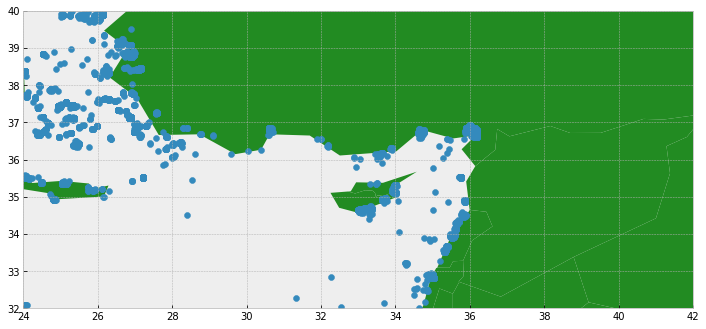

In [26]:
plt.figure(figsize=(12,12))
aoi.plot(color="forestgreen", ax=plt.gca())
locations_eastmediterranean.plot(ax=plt.gca())

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

In [25]:
locs = locations_eastmediterranean.copy()
locs["component"] = -1
locs["cell_x"] = (locs["easting"] / THR).astype(int)
locs["cell_y"] = (locs["northing"] / THR).astype(int)

In [26]:
locs.head()

,easting,northing,zone_number,zone_letter,lat,lon,W,E,S,N,component,geometry,cell_x,cell_y
452,359042.859521,4.028304e+06,35,S,36.38955,25.42832,0,0,0,0,-1,POINT (25.42832 36.38955),35,402
455,359222.293519,4.028249e+06,35,S,36.38908,25.43033,0,0,0,0,-1,POINT (25.43033 36.38908),35,402
457,318285.792025,4.144882e+06,35,S,37.43294,24.94613,0,0,0,0,-1,POINT (24.94613 37.43294),31,414
459,512644.892559,4.057884e+06,35,S,36.66648,27.14150,0,0,0,0,-1,POINT (27.14150 36.66648),51,405
462,279779.571833,4.113606e+06,35,S,37.14293,24.52051,0,0,0,0,-1,POINT (24.52051 37.14293),27,411


In [27]:
locs["border"] = (locs[["N", "E", "S", "W"]].sum(axis=1)!=0).astype(int)

In [28]:
locs

,easting,northing,zone_number,zone_letter,lat,lon,W,E,S,N,component,geometry,cell_x,cell_y,border
452,359042.859521,4.028304e+06,35,S,36.38955,25.42832,0,0,0,0,-1,POINT (25.42832 36.38955),35,402,0
455,359222.293519,4.028249e+06,35,S,36.38908,25.43033,0,0,0,0,-1,POINT (25.43033 36.38908),35,402,0
457,318285.792025,4.144882e+06,35,S,37.43294,24.94613,0,0,0,0,-1,POINT (24.94613 37.43294),31,414,0
459,512644.892559,4.057884e+06,35,S,36.66648,27.14150,0,0,0,0,-1,POINT (27.14150 36.66648),51,405,0
462,279779.571833,4.113606e+06,35,S,37.14293,24.52051,0,0,0,0,-1,POINT (24.52051 37.14293),27,411,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493706,492254.835523,4.292446e+06,35,S,38.78071,26.91083,0,0,0,0,-1,POINT (26.91083 38.78071),49,429,0
1493786,733958.755713,3.754938e+06,36,S,33.90890,35.53044,0,0,0,0,-1,POINT (35.53044 33.90890),73,375,0
1493844,736586.372615,3.757294e+06,36,S,33.92954,35.55947,0,0,0,0,-1,POINT (35.55947 33.92954),73,375,0
1493868,733959.968792,3.754814e+06,36,S,33.90778,35.53042,0,0,0,0,-1,POINT (35.53042 33.90778),73,375,0


## Counts of zone + cell

In [37]:
locs.groupby(["zone_number", "zone_letter", "cell_x", "cell_y"]).size().sort_values(ascending=False) / locs.shape[0]

zone_number  zone_letter  cell_x  cell_y
35           S            49      429       0.135357
36           S            68      363       0.089176
                          64      407       0.089127
37           S            24      406       0.054392
36           S            73      375       0.040906
                                              ...   
35           S            41      415       0.000050
                          37      413       0.000050
36           S            53      382       0.000050
35           S            46      412       0.000050
36           S            52      391       0.000050
Length: 362, dtype: float64

Can we use this as weight?

In [41]:
weight = ((locs
           .groupby(["zone_number", "zone_letter", "cell_x", "cell_y"])
           .size()
           .sort_values(ascending=False)
           .rename("weight")) / locs.shape[0])
locs = locs.merge(weight, left_on=["zone_number", "zone_letter", "cell_x", "cell_y"], right_index=True)

In [56]:
zone_grp = locs.groupby(["zone_number", "zone_letter"])

kdtrees = {}

for zone, zone_locations in tqdm.tqdm(zone_grp, total=len(zone_grp.groups)):
    zn, zl = zone
    zone_mask = (locations_utm.zone_number==zn) & (locations_utm.zone_letter==zl)
    tree = cKDTree(locations_utm.loc[zone_mask, ["easting", "northing"]].values)
    kdtrees[zone] = [locations_utm.loc[zone_mask].index, tree]

100%|██████████| 3/3 [00:00<00:00, 13.39it/s]


## Adding weights

In [29]:
%load_ext line_profiler

In [55]:
%%time

THR = 10000
locs["component"] = -1
current_cid = -1
components = {}

while (locs.component==-1).sum()!=0:
    current_cid += 1
    zones_to_update = set()
    seed = locs[locs.component==-1].sample(1, weights="weight").index[0]

    zn, zl = locs.loc[seed, ["zone_number", "zone_letter"]]
    zone_mask = (locs.zone_number==zn) & (locs.zone_letter==zl)

    component = ConnectedComponent(current_cid, locs, THR)
    component.add(seed)
    locs.loc[seed, "component"] = current_cid

    while not component.is_full():
        component_mask = locs.component==-1

        if not locs.loc[zone_mask & component_mask].empty:
            kdtrees[(zn, zl)] = [locs.loc[zone_mask & component_mask].index,
                                 cKDTree(locs.loc[zone_mask & component_mask,
                                                  ["easting", "northing"]].values)]

            for (lzn, lzl) in zones_to_update:
                local_zone_mask = (locs.zone_number==lzn) & (locs.zone_letter==lzl)
                zone_tree = cKDTree(locs.loc[local_zone_mask & component_mask,
                                             ["easting", "northing"]].values)
                kdtrees[(lzn, lzl)] = [locs.loc[local_zone_mask & component_mask].index, zone_tree]

            zones_to_update = component.grow(kdtrees=kdtrees)
        else:
            component.grow(locs=locs)
        locs.loc[component.elements, "component"] = current_cid

    components[component.cid] = component.elements

CPU times: user 34.7 s, sys: 0 ns, total: 34.7 s
Wall time: 34.7 s


## No weights comparison

In [30]:
zone_grp = locs.groupby(["zone_number", "zone_letter"])

kdtrees = {}

for zone, zone_locations in tqdm.tqdm(zone_grp, total=len(zone_grp.groups)):
    zn, zl = zone
    zone_mask = (locations_utm.zone_number==zn) & (locations_utm.zone_letter==zl)
    tree = cKDTree(locations_utm.loc[zone_mask, ["easting", "northing"]].values)
    kdtrees[zone] = [locations_utm.loc[zone_mask].index, tree]

100%|██████████| 3/3 [00:00<00:00, 14.48it/s]


In [33]:
def run_components(locs, thr, kdtrees):
    """Wrapper for profiling."""

    THR = thr
    locs["component"] = -1
    current_cid = -1
    components = {}

    while (locs.component==-1).sum()!=0:
        current_cid += 1
        zones_to_update = set()
        seed = locs[locs.component==-1].sample(1).index[0]

        zn, zl = locs.loc[seed, ["zone_number", "zone_letter"]]
        zone_mask = (locs.zone_number==zn) & (locs.zone_letter==zl)

        component = ConnectedComponent(current_cid, locs, THR)
        component.add(seed)
        locs.loc[seed, "component"] = current_cid

        while not component.is_full():
            component_mask = locs.component==-1

            if not locs.loc[zone_mask & component_mask].empty:
                kdtrees[(zn, zl)] = [locs.loc[zone_mask & component_mask].index,
                                     cKDTree(locs.loc[zone_mask & component_mask,
                                                      ["easting", "northing"]].values)]

                for (lzn, lzl) in zones_to_update:
                    local_zone_mask = (locs.zone_number==lzn) & (locs.zone_letter==lzl)
                    zone_tree = cKDTree(locs.loc[local_zone_mask & component_mask,
                                                 ["easting", "northing"]].values)
                    kdtrees[(lzn, lzl)] = [locs.loc[local_zone_mask & component_mask].index, zone_tree]

                zones_to_update = component.grow(kdtrees=kdtrees)
            else:
                component.grow(locs=locs)
            locs.loc[component.elements, "component"] = current_cid

        components[component.cid] = component.elements
    return components

In [34]:
%lprun -f run_components run_components(locs, THR, kdtrees)

Ok, `86.7%` + `7%` is spent, unsurprisingly, in `component.grow`. Let's dig in:

In [35]:
%lprun -f run_components -f ConnectedComponent.grow run_components(locs, THR, kdtrees)

Now, `33.2%` is spent in:

```python
zn, zl = self.all_locations.loc[element, ["zone_number", "zone_letter"]]
```

`37.2%` is spent in:

```python
neighbors = get_in_zone_neighbors_kdtree(self.all_locations.loc[element], kdtree, self.thr)
```

and `24.4%`:

```python
cross_zone_neighbors, updated_zones = get_cross_zone_neighbors(self.all_locations.loc[element], locs, self.thr)
```

This is not really good, as we have three sources at once, and none is prevalent.

In [40]:
%timeit locs.loc[457]

95.4 µs ± 3.84 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [41]:
%timeit zn, zl = locs.loc[457, ["zone_number", "zone_letter"]]

381 µs ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [43]:
%timeit zn, zl = locs.loc[457][["zone_number", "zone_letter"]]

393 µs ± 2.87 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [44]:
%timeit zn, zl = locs[["zone_number", "zone_letter"]].loc[457]

673 µs ± 5.74 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [47]:
%%timeit
loc = locs.loc[457]
zn, zl = loc.zone_number, loc.zone_letter

111 µs ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Ok, we can deal with Pandas indexing inefficiencies (which are ok in usual cisrcumstances, but are not when you hit it millions of times).

In [60]:
class ConnectedComponentV1(ConnectedComponent):
    """Connected component entity. New elements can be added, and component can check if it's finished."""

    def grow(self, locs=None, kdtrees=None):
        """Grow this component by elements from `locs`."""

        subset = self.members.difference(self.visited)
        locs = locs if locs is not None else self.all_locations
        current_locs = self.all_locations.loc[subset]
        all_updated_zones = set()

        for element in subset:
            current_loc = current_locs.loc[element]
            zn, zl = current_loc.zone_number, current_loc.zone_letter

            if (kdtrees is not None):
                kdtree = kdtrees[(zn, zl)]
                neighbors = get_in_zone_neighbors_kdtree(current_loc, kdtree, self.thr)
            else:
                neighbors = get_in_zone_neighbors(current_loc, locs, self.thr)

            if current_loc.border:
                cross_zone_neighbors, updated_zones = get_cross_zone_neighbors(current_loc, locs, self.thr)
                neighbors = neighbors.union(cross_zone_neighbors)
                all_updated_zones.update(updated_zones)

            self.members.update(neighbors)
            self.visited.add(element)
        return all_updated_zones

    @property
    def elements(self):
        return list(self.members)

    @property
    def size(self):
        return len(self.members)
    
    
def run_components_v1(locs, thr, kdtrees):
    """Wrapper for profiling."""

    THR = thr
    locs["component"] = -1
    current_cid = -1
    components = {}

    while (locs.component==-1).sum()!=0:
        current_cid += 1
        zones_to_update = set()
        seed = locs[locs.component==-1].sample(1).index[0]

        zn, zl = locs.loc[seed, ["zone_number", "zone_letter"]]
        zone_mask = (locs.zone_number==zn) & (locs.zone_letter==zl)

        component = ConnectedComponentV1(current_cid, locs, THR)
        component.add(seed)
        locs.loc[seed, "component"] = current_cid

        while not component.is_full():
            component_mask = locs.component==-1

            if not locs.loc[zone_mask & component_mask].empty:
                kdtrees[(zn, zl)] = [locs.loc[zone_mask & component_mask].index,
                                     cKDTree(locs.loc[zone_mask & component_mask,
                                                      ["easting", "northing"]].values)]

                for (lzn, lzl) in zones_to_update:
                    local_zone_mask = (locs.zone_number==lzn) & (locs.zone_letter==lzl)
                    zone_tree = cKDTree(locs.loc[local_zone_mask & component_mask,
                                                 ["easting", "northing"]].values)
                    kdtrees[(lzn, lzl)] = [locs.loc[local_zone_mask & component_mask].index, zone_tree]

                zones_to_update = component.grow(kdtrees=kdtrees)
            else:
                component.grow(locs=locs)
            locs.loc[component.elements, "component"] = current_cid

        components[component.cid] = component.elements
    return components

In [52]:
%lprun -f ConnectedComponentV1.grow run_components_v1(locs, THR, kdtrees)

Ok, now getting neighbors (in-zone and cross-zone) takes `40.4% + 35.5%`. Let's take another level:

In [56]:
%lprun -f get_in_zone_neighbors_kdtree -f get_cross_zone_neighbors -f get_cross_zone_distances run_components_v1(locs, THR, kdtrees)

```
Timer unit: 1e-06 s

Total time: 2.86658 s
File: <ipython-input-18-4db6c3c5b60c>
Function: get_cross_zone_distances at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     6                                           def get_cross_zone_distances(loc, locs):
     7                                               """Calculate distances between `loc` and all location in `locs` in the same zone."""
     8                                           
     9      1134     634512.0    559.5     22.1      dphi_sqr = np.square(locs["lat"] - loc["lat"])
    10      1134     615093.0    542.4     21.5      dlambda_sqr = np.square(locs["lon"] - loc["lon"])
    11      1134    1616974.0   1425.9     56.4      return R * np.sqrt(dphi_sqr + np.cos(loc.lat * np.pi / 180) * dlambda_sqr) * np.pi / 180

Total time: 16.9324 s
File: <ipython-input-18-4db6c3c5b60c>
Function: get_in_zone_neighbors_kdtree at line 14

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    14                                           def get_in_zone_neighbors_kdtree(loc, tree, thr):
    15                                               """Calculate neighbors of `loc` in the same zone."""
    16                                           
    17     19721      41257.0      2.1      0.2      tree_elements, tree = tree
    18     19721   16189382.0    820.9     95.6      neighbors = tree.query_ball_point(loc[["easting", "northing"]], THR)
    19                                           
    20     19721     701758.0     35.6      4.1      return tree_elements[neighbors]

Total time: 15.0019 s
File: <ipython-input-18-4db6c3c5b60c>
Function: get_cross_zone_neighbors at line 37

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    37                                           def get_cross_zone_neighbors(loc, locs, thr):
    38                                               """Calculate neighbors of `loc` in the same zone."""
    39                                           
    40      1112       2255.0      2.0      0.0      updated_zones = []
    41      1112     811390.0    729.7      5.4      border_status = loc[["N", "S", "E", "W"]]
    42      1112     408127.0    367.0      2.7      border_list = border_status[border_status!=0].index.tolist()
    43      1112      73355.0     66.0      0.5      neigboring_zones = get_neighboring_zones(loc.zone_number, loc.zone_letter, border_list)
    44                                           
    45      1112       2092.0      1.9      0.0      neighbors = []
    46                                           
    47      2246       5110.0      2.3      0.0      for (zn, zl), borders in neigboring_zones.items():
    48      1134    1579078.0   1392.5     10.5          zone_mask = (locs.zone_number==zn) & (locs.zone_letter==zl)
    49      1134    1833800.0   1617.1     12.2          border_mask = locs[borders].sum(axis=1)!=0
    50      1134    2045029.0   1803.4     13.6          candidates = locs[zone_mask & border_mask & (locs.component==-1)]
    51                                           
    52      1134    2880668.0   2540.3     19.2          dist = get_cross_zone_distances(loc, candidates)
    53      1134    1589117.0   1401.3     10.6          neighbors.append(candidates[dist<=thr])
    54                                           
    55      1134    1589022.0   1401.3     10.6          if not candidates[dist<=thr].empty:    
    56       183        466.0      2.5      0.0              updated_zones.append((zn, zl))
    57                                           
    58      1112    2182345.0   1962.5     14.5      return pd.concat(neighbors).index, updated_zones
```

Ok, multiple issues here:

- too much boolean indexing,
- repeating operations,
- unneeded calculations.

In [61]:
PI_180 = np.pi / 180
PI_90 = np.pi / 90

def get_cross_zone_distances(loc, locs):
    """Calculate distances between `loc` and all location in `locs` in the same zone."""

    dphi_sqr = np.square(locs["lat"] - loc["lat"])
    dlambda_sqr = np.square(locs["lon"] - loc["lon"])
    return R * R * (dphi_sqr + 0.5 * (1 + np.cos(loc.lat * PI_90)) * dlambda_sqr) * PI_180


def get_cross_zone_neighbors(loc, locs, thr):
    """Calculate neighbors of `loc` in the same zone."""

    updated_zones = []
    border_status = loc[["N", "S", "E", "W"]]
    border_list = border_status[border_status!=0].index.tolist()
    neigboring_zones = get_neighboring_zones(loc.zone_number, loc.zone_letter, border_list)

    neighbors = []

    for (zn, zl), borders in neigboring_zones.items():
        zone_mask = (locs.zone_number==zn) & (locs.zone_letter==zl)
        border_mask = locs.border != 0
        candidates = locs[zone_mask & border_mask & (locs.component==-1)]

        dist = get_cross_zone_distances(loc, candidates)
        zone_neighbors = candidates[dist <= thr * thr]
        neighbors.append(zone_neighbors)

        if not zone_neighbors.empty:    
            updated_zones.append((zn, zl))

    return pd.concat(neighbors).index, updated_zones

In [62]:
%lprun -f get_in_zone_neighbors_kdtree -f get_cross_zone_neighbors -f get_cross_zone_distances run_components_v1(locs, THR, kdtrees)

```
Timer unit: 1e-06 s

Total time: 16.0084 s
File: <ipython-input-18-4db6c3c5b60c>
Function: get_in_zone_neighbors_kdtree at line 14

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    14                                           def get_in_zone_neighbors_kdtree(loc, tree, thr):
    15                                               """Calculate neighbors of `loc` in the same zone."""
    16                                           
    17     19624      38472.0      2.0      0.2      tree_elements, tree = tree
    18     19624   15303103.0    779.8     95.6      neighbors = tree.query_ball_point(loc[["easting", "northing"]], THR)
    19                                           
    20     19624     666831.0     34.0      4.2      return tree_elements[neighbors]

Total time: 2.26555 s
File: <ipython-input-61-5f56a3948390>
Function: get_cross_zone_distances at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     4                                           def get_cross_zone_distances(loc, locs):
     5                                               """Calculate distances between `loc` and all location in `locs` in the same zone."""
     6                                           
     7      1134     605879.0    534.3     26.7      dphi_sqr = np.square(locs["lat"] - loc["lat"])
     8      1134     590568.0    520.8     26.1      dlambda_sqr = np.square(locs["lon"] - loc["lon"])
     9      1134    1069099.0    942.8     47.2      return R * R * (dphi_sqr + 0.5 * (1 + np.cos(loc.lat * PI_90)) * dlambda_sqr) * PI_180

Total time: 10.8859 s
File: <ipython-input-61-5f56a3948390>
Function: get_cross_zone_neighbors at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    12                                           def get_cross_zone_neighbors(loc, locs, thr):
    13                                               """Calculate neighbors of `loc` in the same zone."""
    14                                           
    15      1112       2277.0      2.0      0.0      updated_zones = []
    16      1112     778142.0    699.8      7.1      border_status = loc[["N", "S", "E", "W"]]
    17      1112     391413.0    352.0      3.6      border_list = border_status[border_status!=0].index.tolist()
    18      1112      69724.0     62.7      0.6      neigboring_zones = get_neighboring_zones(loc.zone_number, loc.zone_letter, border_list)
    19                                           
    20      1112       2013.0      1.8      0.0      neighbors = []
    21                                           
    22      2246       4316.0      1.9      0.0      for (zn, zl), borders in neigboring_zones.items():
    23      1134    1507871.0   1329.7     13.9          zone_mask = (locs.zone_number==zn) & (locs.zone_letter==zl)
    24      1134     311284.0    274.5      2.9          border_mask = locs.border != 0
    25      1134    1946836.0   1716.8     17.9          candidates = locs[zone_mask & border_mask & (locs.component==-1)]
    26                                           
    27      1134    2279104.0   2009.8     20.9          dist = get_cross_zone_distances(loc, candidates)
    28      1134    1503922.0   1326.2     13.8          zone_neighbors = candidates[dist <= thr * thr]
    29      1134       2824.0      2.5      0.0          neighbors.append(zone_neighbors)
    30                                           
    31      1134       9486.0      8.4      0.1          if not zone_neighbors.empty:    
    32        41         82.0      2.0      0.0              updated_zones.append((zn, zl))
    33                                           
    34      1112    2076631.0   1867.5     19.1      return pd.concat(neighbors).index, updated_zones
```

Next: we know, that we update `component` column only between growth iterations. Hence, we can remove all the masks with `locs.component==-1` and calculate it once per iteration.

In [72]:
def get_in_zone_distances(loc, locs):
    """Calculate distances between `loc` and all location in `locs` in the same zone."""
    return np.square(locs[["easting", "northing"]] - loc[["easting", "northing"]]).sum(axis=1)


def get_in_zone_neighbors_kdtree(loc, tree, thr):
    """Calculate neighbors of `loc` in the same zone."""

    tree_elements, tree = tree
    neighbors = tree.query_ball_point(loc[["easting", "northing"]], THR)

    return tree_elements[neighbors]


def get_cross_zone_distances(loc, locs):
    """Calculate distances between `loc` and all location in `locs` in the same zone."""

    dphi_sqr = np.square(locs["lat"] - loc["lat"])
    dlambda_sqr = np.square(locs["lon"] - loc["lon"])
    return R * R * (dphi_sqr + 0.5 * (1 + np.cos(loc.lat * PI_90)) * dlambda_sqr) * PI_180


def get_cross_zone_neighbors(loc, locs, thr):
    """Calculate neighbors of `loc` in the same zone."""

    updated_zones = []
    border_status = loc[["N", "S", "E", "W"]]
    border_list = border_status[border_status!=0].index.tolist()
    neigboring_zones = get_neighboring_zones(loc.zone_number, loc.zone_letter, border_list)

    neighbors = pd.Index([])

    for (zn, zl), borders in neigboring_zones.items():
        zone_mask = (locs.zone_number==zn) & (locs.zone_letter==zl)
        border_mask = locs.border != 0
        candidates = locs[zone_mask & border_mask]

        dist = get_cross_zone_distances(loc, candidates)
        zone_neighbors = candidates[dist <= thr * thr]
        neighbors.union(zone_neighbors.index)

        if not zone_neighbors.empty:    
            updated_zones.append((zn, zl))

    return neighbors, updated_zones


class ConnectedComponentV2(ConnectedComponent):
    """Connected component entity. New elements can be added, and component can check if it's finished."""

    def grow(self, locs=None, kdtrees=None):
        """Grow this component by elements from `locs`."""

        subset = self.members.difference(self.visited)
        locs = locs if locs is not None else self.all_locations
        current_locs = self.all_locations.loc[subset]
        valid_locs = locs[locs.component!=-1]
        all_updated_zones = set()

        for element in subset:
            current_loc = current_locs.loc[element]
            zn, zl = current_loc.zone_number, current_loc.zone_letter

            if (kdtrees is not None):
                kdtree = kdtrees[(zn, zl)]
                neighbors = get_in_zone_neighbors_kdtree(current_loc, kdtree, self.thr)
            else:
                neighbors = get_in_zone_neighbors(current_loc, valid_locs, self.thr)

            if current_loc.border:
                cross_zone_neighbors, updated_zones = get_cross_zone_neighbors(current_loc, valid_locs, self.thr)
                neighbors = neighbors.union(cross_zone_neighbors)
                all_updated_zones.update(updated_zones)

            self.members.update(neighbors)
            self.visited.add(element)
        return all_updated_zones
    
def run_components_v2(locs, thr, kdtrees):
    """Wrapper for profiling."""

    THR = thr
    locs["component"] = -1
    current_cid = -1
    components = {}

    while (locs.component==-1).sum()!=0:
        current_cid += 1
        zones_to_update = set()
        seed = locs[locs.component==-1].sample(1).index[0]

        zn, zl = locs.loc[seed, ["zone_number", "zone_letter"]]
        zone_mask = (locs.zone_number==zn) & (locs.zone_letter==zl)

        component = ConnectedComponentV2(current_cid, locs, THR)
        component.add(seed)
        locs.loc[seed, "component"] = current_cid

        while not component.is_full():
            component_mask = locs.component==-1

            if not locs.loc[zone_mask & component_mask].empty:
                kdtrees[(zn, zl)] = [locs.loc[zone_mask & component_mask].index,
                                     cKDTree(locs.loc[zone_mask & component_mask,
                                                      ["easting", "northing"]].values)]

                for (lzn, lzl) in zones_to_update:
                    local_zone_mask = (locs.zone_number==lzn) & (locs.zone_letter==lzl)
                    zone_tree = cKDTree(locs.loc[local_zone_mask & component_mask,
                                                 ["easting", "northing"]].values)
                    kdtrees[(lzn, lzl)] = [locs.loc[local_zone_mask & component_mask].index, zone_tree]

                zones_to_update = component.grow(kdtrees=kdtrees)
            else:
                component.grow(locs=locs)
            locs.loc[component.elements, "component"] = current_cid

        components[component.cid] = component.elements
    return components

In [73]:
%lprun -f get_in_zone_neighbors_kdtree -f get_cross_zone_neighbors -f get_cross_zone_distances run_components_v2(locs, THR, kdtrees)

In [74]:
zone_grp = locs.groupby(["zone_number", "zone_letter"])

kdtrees = {}

for zone, zone_locations in tqdm.tqdm(zone_grp, total=len(zone_grp.groups)):
    zn, zl = zone
    zone_mask = (locations_utm.zone_number==zn) & (locations_utm.zone_letter==zl)
    tree = cKDTree(locations_utm.loc[zone_mask, ["easting", "northing"]].values)
    kdtrees[zone] = [locations_utm.loc[zone_mask].index, tree]

100%|██████████| 3/3 [00:00<00:00, 15.22it/s]


In [75]:
%%time

THR = 10000
locs["component"] = -1
current_cid = -1
components = {}

while (locs.component==-1).sum()!=0:
    current_cid += 1
    zones_to_update = set()
    seed = locs[locs.component==-1].sample(1).index[0]

    zn, zl = locs.loc[seed, ["zone_number", "zone_letter"]]
    zone_mask = (locs.zone_number==zn) & (locs.zone_letter==zl)

    component = ConnectedComponentV2(current_cid, locs, THR)
    component.add(seed)
    locs.loc[seed, "component"] = current_cid

    while not component.is_full():
        component_mask = locs.component==-1

        if not locs.loc[zone_mask & component_mask].empty:
            kdtrees[(zn, zl)] = [locs.loc[zone_mask & component_mask].index,
                                 cKDTree(locs.loc[zone_mask & component_mask,
                                                  ["easting", "northing"]].values)]

            for (lzn, lzl) in zones_to_update:
                local_zone_mask = (locs.zone_number==lzn) & (locs.zone_letter==lzl)
                zone_tree = cKDTree(locs.loc[local_zone_mask & component_mask,
                                             ["easting", "northing"]].values)
                kdtrees[(lzn, lzl)] = [locs.loc[local_zone_mask & component_mask].index, zone_tree]

            zones_to_update = component.grow(kdtrees=kdtrees)
        else:
            component.grow(locs=locs)
        locs.loc[component.elements, "component"] = current_cid

    components[component.cid] = component.elements

CPU times: user 18.1 s, sys: 8.19 ms, total: 18.1 s
Wall time: 18 s


Ok, we get `18s` vs. `33-35s`. This is only with obvious non-algorithmic optimizations.

# Idea: using `kdtree.query_pairs`

In [30]:
zone_grp = locs.groupby(["zone_number", "zone_letter"])

kdtrees = {}

for zone, zone_locations in tqdm.tqdm(zone_grp, total=len(zone_grp.groups)):
    zn, zl = zone
    zone_mask = (locations_utm.zone_number==zn) & (locations_utm.zone_letter==zl)
    tree = cKDTree(locations_utm.loc[zone_mask, ["easting", "northing"]].values)
    kdtrees[zone] = [locations_utm.loc[zone_mask].index, tree]

100%|██████████| 3/3 [00:00<00:00, 11.46it/s]


In [67]:
%time sorted(kdtrees[(35, "S")][1].query_pairs(10000))[:10]

CPU times: user 14.5 s, sys: 364 ms, total: 14.9 s
Wall time: 14.8 s


[(0, 1),
 (0, 6),
 (0, 7),
 (0, 9),
 (0, 11),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 19),
 (0, 21)]

This one is a bit memory hungry (as we need to create all the paris for the zone at start). We now need to smash these paris into (in-zone) components.

In [32]:
sample_zone_pairs = sorted(kdtrees[(35, "S")][1].query_pairs(10000))

In [33]:
sample_zone_pairs[:10]

[(0, 1),
 (0, 6),
 (0, 7),
 (0, 9),
 (0, 11),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 19),
 (0, 21)]

In [35]:
len(sample_zone_pairs)

5590965

We now need to restructure this list of tuples to get components.

In [39]:
from collections import defaultdict

In [40]:
neighbors = defaultdict(list)

for loc, neighbor in sample_zone_pairs:
    neighbors[loc].append(neighbor)

This restructuring is very fast, so we can neglect it compared to getting pairs.

In [44]:
def get_neighbors(locations, zone, thr, tree=None, mask=None):
    """Calculate dictionary of neighbors."""

    zn, zl = zone
    zone_mask = (locations.zone_number==zn) & (locations.zone_letter==zl)

    if mask is not None:
        zone_mask &= mask
    tree = tree or cKDTree(locations.loc[zone_mask, ["easting", "northing"]].values)
    pairs = sorted(tree.query_pairs(thr))

    neighbors = defaultdict(list)

    for loc, neighbor in pairs:
        neighbors[loc].append(neighbor)
    return neighbors

In [47]:
%time n = get_neighbors(locations_utm, (35, "S"), 10000)

CPU times: user 13.8 s, sys: 304 ms, total: 14.1 s
Wall time: 14.1 s


# Crash test: zones with problematic components

## 52T & 53T

In [32]:
zone_52T = (locations_utm.zone_letter=="T") & (locations_utm.zone_number==52)
zone_53T = (locations_utm.zone_letter=="T") & (locations_utm.zone_number==53)

locations_5253 = locations_utm[zone_52T | zone_53T]
locations_5253 = gpd.GeoDataFrame(locations_5253,
                                  geometry=gpd.points_from_xy(locations_5253["lon"],
                                                              locations_5253["lat"]),
                                  crs="EPSG:4326")

In [33]:
locs = locations_5253.copy()
locs["component"] = -1
locs["cell_x"] = (locs["easting"] / THR).astype(int)
locs["cell_y"] = (locs["northing"] / THR).astype(int)

In [34]:
locs.head()

,easting,northing,zone_number,zone_letter,lat,lon,W,E,S,N,component,geometry,cell_x,cell_y
6145,330531.323277,4.734414e+06,53,T,42.74353,132.92947,0,0,0,0,-1,POINT (132.92947 42.74353),33,473
19303,331583.034436,4.738009e+06,53,T,42.77612,132.94124,0,0,0,0,-1,POINT (132.94124 42.77612),33,473
28814,734152.039734,4.775831e+06,52,T,43.09903,131.87728,0,1,0,0,-1,POINT (131.87728 43.09903),73,477
35082,737674.108755,4.776778e+06,52,T,43.10645,131.92091,0,1,0,0,-1,POINT (131.92091 43.10645),73,477
35083,734220.217182,4.774795e+06,52,T,43.08969,131.87768,0,1,0,0,-1,POINT (131.87768 43.08969),73,477


In [35]:
locs["border"] = (locs[["N", "E", "S", "W"]].sum(axis=1)!=0).astype(int)

In [41]:
zone_grp = locs.groupby(["zone_number", "zone_letter"])

kdtrees = {}

for zone, zone_locations in tqdm.tqdm(zone_grp, total=len(zone_grp.groups)):
    zn, zl = zone
    zone_mask = (locations_utm.zone_number==zn) & (locations_utm.zone_letter==zl)
    tree = cKDTree(locations_utm.loc[zone_mask, ["easting", "northing"]].values)
    kdtrees[zone] = [locations_utm.loc[zone_mask].index, tree]

100%|██████████| 2/2 [00:00<00:00, 11.71it/s]


In [47]:
%time n = get_neighbors(locations_utm, (52, "T"), 10000)

CPU times: user 45.6 s, sys: 580 ms, total: 46.2 s
Wall time: 46.1 s


In [48]:
%time n = get_neighbors(locations_utm, (53, "T"), 10000)

CPU times: user 9.59 s, sys: 31.8 ms, total: 9.62 s
Wall time: 9.6 s


In previous implementation, this component took 7 minutes to calculate. Now it seems we can do better, as getting all the neighbors takes only `55s`. We only need an efficient components calculation from the neighbors dictionary and between-zone components merging.

In [49]:
import gc

del n
gc.collect()

22

## 50R/S & 51R/S

In [50]:
zone_50R = (locations_utm.zone_letter=="R") & (locations_utm.zone_number==50)
zone_50S = (locations_utm.zone_letter=="S") & (locations_utm.zone_number==50)
zone_51R = (locations_utm.zone_letter=="R") & (locations_utm.zone_number==51)
zone_51S = (locations_utm.zone_letter=="S") & (locations_utm.zone_number==51)

locations_5051 = locations_utm[zone_50R | zone_50S | zone_51R | zone_51S]
locations_5051 = gpd.GeoDataFrame(locations_5051,
                                  geometry=gpd.points_from_xy(locations_5051["lon"],
                                                              locations_5051["lat"]),
                                  crs="EPSG:4326")

In [51]:
locs = locations_5051.copy()
locs["component"] = -1
locs["cell_x"] = (locs["easting"] / THR).astype(int)
locs["cell_y"] = (locs["northing"] / THR).astype(int)

In [52]:
locs.head()

,easting,northing,zone_number,zone_letter,lat,lon,W,E,S,N,component,geometry,cell_x,cell_y
1678,351761.043086,3.598439e+06,51,S,32.51337,121.42182,0,0,0,0,-1,POINT (121.42182 32.51337),35,359
1679,336357.225839,3.396546e+06,51,R,30.69048,121.29147,0,0,0,0,-1,POINT (121.29147 30.69048),33,339
1680,378783.788119,3.317452e+06,51,R,29.98197,121.74347,0,0,0,0,-1,POINT (121.74347 29.98197),37,331
1681,352053.701584,3.405006e+06,51,R,30.76885,121.45408,0,0,0,0,-1,POINT (121.45408 30.76885),35,340
1682,379270.911747,3.316732e+06,51,R,29.97552,121.74860,0,0,0,0,-1,POINT (121.74860 29.97552),37,331


In [53]:
locs["border"] = (locs[["N", "E", "S", "W"]].sum(axis=1)!=0).astype(int)

In [54]:
zone_grp = locs.groupby(["zone_number", "zone_letter"])

kdtrees = {}

for zone, zone_locations in tqdm.tqdm(zone_grp, total=len(zone_grp.groups)):
    zn, zl = zone
    zone_mask = (locations_utm.zone_number==zn) & (locations_utm.zone_letter==zl)
    tree = cKDTree(locations_utm.loc[zone_mask, ["easting", "northing"]].values)
    kdtrees[zone] = [locations_utm.loc[zone_mask].index, tree]

100%|██████████| 4/4 [00:00<00:00,  8.25it/s]


In [55]:
%time n = get_neighbors(locations_utm, (50, "R"), 10000)

CPU times: user 24.3 s, sys: 268 ms, total: 24.5 s
Wall time: 24.5 s


In [56]:
del n
gc.collect()

22

Here we crash on memory:

In [ ]:
%time n = get_neighbors(locations_utm, (50, "S"), 10000)

In [ ]:
del n
gc.collect()

In [ ]:
%time n = get_neighbors(locations_utm, (51, "R"), 10000)

In [ ]:
del n
gc.collect()

In [ ]:
%time n = get_neighbors(locations_utm, (51, "S"), 10000)

In [ ]:
del n
gc.collect()

Not sure if this will work, but may be interesting.